In [21]:
# BLOCCO 1: Confronto Attributi Dataset Zeek
# Controllo e uniformazione colonne tra UWF-ZeekData22 e UWF-ZeekDataFall22

import os
import pandas as pd

# ------------- Blocchi 1 e 2: Definizione dei percorsi -------------
# Blocco 1: Cartella ZeekData22
folder_data22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekData22"

# Blocco 2: Cartella ZeekDataFall22
folder_datafall22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"

# Funzione per caricare tutti i parquet e csv di una cartella in un unico DataFrame
def load_dataset(folder_path):
    all_files = os.listdir(folder_path)
    dfs = []
    for f in all_files:
        path = os.path.join(folder_path, f)
        if f.endswith(".parquet"):
            dfs.append(pd.read_parquet(path))
        elif f.endswith(".csv"):
            dfs.append(pd.read_csv(path))
    if dfs:
        # Concateno tutto in un unico dataframe
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()

# ------------- Blocco 3: Caricamento dataset -------------
df_22 = load_dataset(folder_data22)
df_fall22 = load_dataset(folder_datafall22)

# ------------- Blocco 4: Controllo colonne -------------
cols_22 = set(df_22.columns)
cols_fall22 = set(df_fall22.columns)

# Colonne uniche per ciascun dataset
unique_22 = cols_22 - cols_fall22
unique_fall22 = cols_fall22 - cols_22
common_cols = cols_22 & cols_fall22

# ------------- Blocco 5: Stampa report differenze -------------
print("=== BLOCCO 5: Report differenze tra dataset ===\n")
print(f"Totale colonne in ZeekData22: {len(cols_22)}")
print(f"Totale colonne in ZeekDataFall22: {len(cols_fall22)}\n")

print("Colonne presenti solo in ZeekData22:")
for col in sorted(unique_22):
    print(f"  - {col}")
print("\nColonne presenti solo in ZeekDataFall22:")
for col in sorted(unique_fall22):
    print(f"  - {col}")
print("\nColonne comuni a entrambi i dataset:")
for col in sorted(common_cols):
    print(f"  - {col}")


=== BLOCCO 5: Report differenze tra dataset ===

Totale colonne in ZeekData22: 37
Totale colonne in ZeekDataFall22: 38

Colonne presenti solo in ZeekData22:
  - 2022-01-09 - 2022-01-16
  - 2022-01-16 - 2022-01-23
  - 2022-02-06 - 2022-02-13
  - 2022-02-13 - 2022-02-20
  - dest_ip
  - dest_port
  - mitre_attack_tactics
  - protocol
  - src_ip
  - src_port

Colonne presenti solo in ZeekDataFall22:
  - 2022-08-28 - 2022-09-04
  - 2022-09-04 - 2022-09-11
  - 2022-09-11 - 2022-09-18
  - 2022-09-18 - 2022-09-25
  - 2022-09-25 - 2022-10-02
  - 2022-10-02 - 2022-10-09
  - 2022-10-09 - 2022-10-16
  - 2022-10-16 - 2022-10-23
  - 2022-10-23 - 2022-10-30
  - label_binary
  - label_technique

Colonne comuni a entrambi i dataset:
  - 2021-12-12 - 2021-12-19
  - 2021-12-19 - 2021-12-26
  - 2021-12-26 - 2022-01-02
  - 2022-01-02 - 2022-01-09
  - community_id
  - conn_state
  - datetime
  - dest_ip_zeek
  - dest_port_zeek
  - duration
  - history
  - label_tactic
  - local_orig
  - local_resp
  - misse

In [22]:
# BLOCCO 1: Data Cleaning su ZeekDataFall22
# Scopo:
# 1. Rimuovere duplicati: log di connessioni identici possono alterare l'addestramento
# 2. Imputare valori mancanti: evitare errori negli algoritmi ML e ridurre bias
# 3. Aggregazioni (session-level features): combinare più record di connessione in metriche significative
#    come totale pacchetti per sessione o durata media, per rendere il modello più robusto

import os
import pandas as pd
import glob
from tqdm import tqdm

# Percorso cartella contenente i file parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# Caricamento dati in un unico DataFrame
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))

data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe prima del cleaning: {len(data)}")
print(f"Totale colonne: {data.shape[1]}")

# ==========================
# 1. Rimozione duplicati
# ==========================
duplicates_before = data.duplicated().sum()
data = data.drop_duplicates()
duplicates_after = data.duplicated().sum()
print(f"Duplicati trovati e rimossi: {duplicates_before - duplicates_after}")

# ==========================
# 2. Imputazione valori mancanti
# ==========================
# Strategia: 
# - numeriche → media
# - categoriali → moda
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['object','category']).columns

imputation_count = 0

for col in num_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mean(), inplace=True)
        imputation_count += missing

for col in cat_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)
        imputation_count += missing

print(f"Totale valori imputati: {imputation_count}")

# ==========================
# 3. Aggregazioni (session-level features)
# ==========================
# Spiegazione:
# - Le connessioni multiple tra gli stessi host possono essere aggregate in sessioni
# - Feature utili: totale pacchetti, byte totali, durata media
# - Questo permette al modello di avere una visione più globale del comportamento di rete
# - Qui consideriamo 'uid' come identificativo della sessione

session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# Unione delle aggregazioni col dataframe originale per eventuali altre feature
data = pd.merge(data, session_features, on='uid', how='left')

# Mostriamo le prime righe del dataframe pulito
print("Prime righe del dataset dopo cleaning e aggregazioni:")
display(data.head())


Caricamento file parquet: 100%|██████████| 13/13 [00:01<00:00, 10.39it/s]


Totale righe prima del cleaning: 700340
Totale colonne: 25
Duplicati trovati e rimossi: 16745
Totale valori imputati: 1219118
Totale sessioni aggregate: 660373
Prime righe del dataset dopo cleaning e aggregazioni:


,community_id,conn_state,duration,history,src_ip_zeek,src_port_zeek,dest_ip_zeek,dest_port_zeek,local_orig,local_resp,...,uid,datetime,label_tactic,label_technique,label_binary,total_orig_bytes,total_resp_bytes,total_orig_pkts,total_resp_pkts,mean_duration
0,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1546,True,44.0,7388.0,28,20,41.878964
1,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Privilege Escalation,Duplicate,Duplicate,44.0,7388.0,28,20,41.878964
2,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Defense Evasion,T1112,True,44.0,7388.0,28,20,41.878964
3,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1547,True,44.0,7388.0,28,20,41.878964
4,1:52yAKDtnHSPDIljwNPlA+UWODdA=,SF,0.041849,ShAdDFaf,143.88.10.11,57042,143.88.10.16,9999,False,False,...,CqO92B3QWHYhyPdtse,2022-10-05 18:14:34.531,Execution,T1059,True,114.0,73.0,9,6,0.041849


⚠️ Campioni benigni rilevati: 350339 / 683595 (51.25%)


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


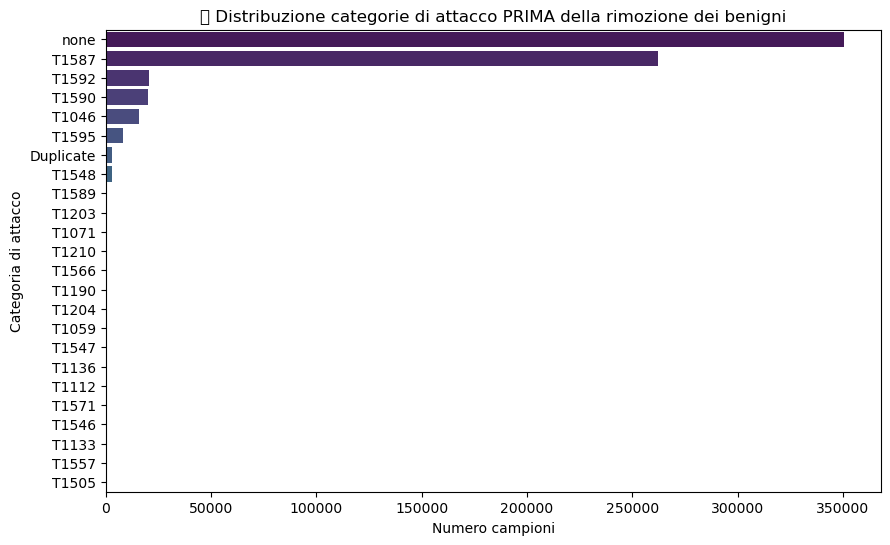

✅ Dopo rimozione benigni: 333256 righe rimanenti.

📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):


,Conteggio,Percentuale (%)
label_technique,,
T1587,262409,78.74
T1592,20382,6.12
T1590,20183,6.06
T1046,16025,4.81
T1595,8104,2.43
Duplicate,2899,0.87
T1548,2893,0.87
T1589,278,0.08
T1203,18,0.01


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


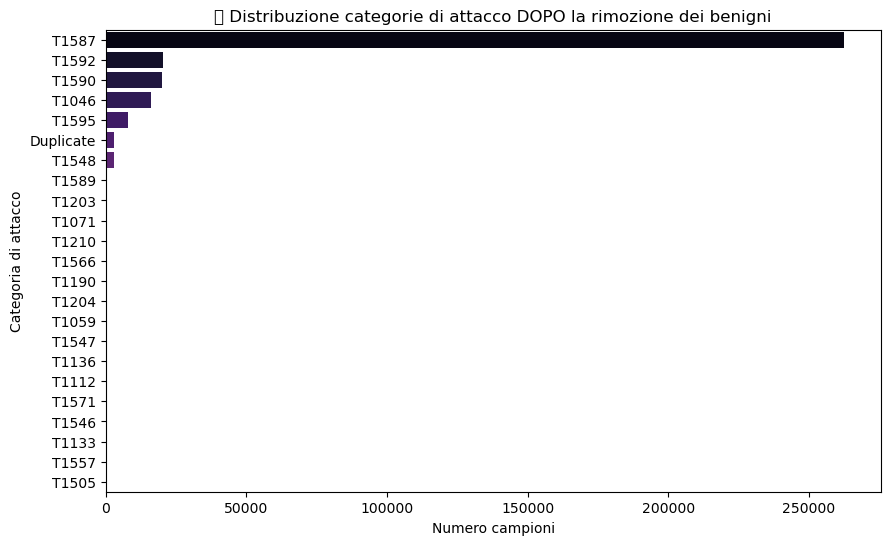

In [23]:
# ==========================================================
# BLOCCO: Rimozione traffico benigno ("none") per multiclasse
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Prima della rimozione -----
total_count = len(data)
none_count = (data['label_technique'] == 'none').sum()
print(f"⚠️ Campioni benigni rilevati: {none_count} / {total_count} ({none_count/total_count*100:.2f}%)")

# Distribuzione prima della rimozione
attack_counts_before = data['label_technique'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_before.index, x=attack_counts_before.values, palette='viridis')
plt.title("📊 Distribuzione categorie di attacco PRIMA della rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Rimozione righe con label_technique 'none' -----
data = data[data['label_technique'] != 'none'].reset_index(drop=True)
print(f"✅ Dopo rimozione benigni: {len(data)} righe rimanenti.")

# ----- Dopo la rimozione -----
attack_counts_after = data['label_technique'].value_counts().sort_values(ascending=False)
attack_percent_after = (attack_counts_after / len(data) * 100).round(2)
attack_df_after = pd.DataFrame({
    'Conteggio': attack_counts_after,
    'Percentuale (%)': attack_percent_after
})
print("\n📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):")
display(attack_df_after)

# Aggiornamento grafico dopo rimozione
plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_after.index, x=attack_counts_after.values, palette='magma')
plt.title("📊 Distribuzione categorie di attacco DOPO la rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Aggiornamento mapping tactic se esiste -----
if 'tactic' in data.columns:
    tactic_counts_after = data['tactic'].value_counts().sort_values(ascending=False)
    tactic_percent_after = (tactic_counts_after / len(data) * 100).round(2)
    tactic_df_after = pd.DataFrame({
        'Conteggio': tactic_counts_after,
        'Percentuale (%)': tactic_percent_after
    })
    print("\n📊 Distribuzione aggiornata per tactic (benigni rimossi):")
    display(tactic_df_after)


In [24]:
# BLOCCO 2: Controllo valori nulli e riepilogo colonne/feature

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]

if len(null_cols) == 0:
    print("✅ Non ci sono valori nulli residui.")
else:
    print("⚠️ Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\n📊 Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\n🔹 Feature numeriche:")
print(num_features)
print("\n🔹 Feature categoriali:")
print(cat_features)


✅ Non ci sono valori nulli residui.

📊 Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

🔹 Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

🔹 Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_binary']


In [25]:
# BLOCCO 3b: Analisi feature numeriche e gestione outlier separata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================
# Step 0: Pulizia sicura della label_binary
# ==============================================
# Alcuni valori in label_binary non sono True/False (es. 'Duplicate'), quindi li mappiamo a 1/0
# Altri valori non convertibili diventano NaN e vengono rimossi
data['label_binary_clean'] = data['label_binary'].map({
    True: 1, False: 0, 'True': 1, 'False': 0, 1: 1, 0: 0
})
invalid_labels = data['label_binary_clean'].isna().sum()
print(f"⚠️ Numero di valori non convertibili in label_binary: {invalid_labels}")

# Eliminazione righe con label non convertibili
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])
print("✅ label_binary pronta per l'analisi numerica.\n")

# ==============================================
# Step 1: Identificazione feature numeriche candidate
# ==============================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
# Rimuoviamo eventuali label numeriche dalla lista delle feature
for col in ['label_binary','label_technique']:
    if col in num_features:
        num_features.remove(col)

print(f"🔹 Feature numeriche candidate: {num_features}\n")

# ==============================================
# Step 2: Analisi varianza e correlazione con label
# ==============================================
# 1️⃣ Varianza: feature quasi costanti non informative
variance = data[num_features].var().sort_values(ascending=False)
print("📊 Varianza delle feature numeriche:")
display(variance)

var_threshold = 0.01
selected_features = variance[variance > var_threshold].index.tolist()
print(f"\n✅ Feature con varianza significativa: {selected_features}")
print("📝 Criterio: distinguono le osservazioni e aiutano il modello.\n")

# 2️⃣ Correlazione con label_binary
corr_with_label = data[selected_features].corrwith(data['label_binary']).sort_values(key=abs, ascending=False)
print("📊 Correlazione con label_binary (valori assoluti ordinati):")
display(corr_with_label)

corr_threshold = 0.05
final_features = corr_with_label[abs(corr_with_label) > corr_threshold].index.tolist()
print(f"\n✅ Feature selezionate (varianza + correlazione): {final_features}")
print("📝 Criterio: feature correlate alla label forniscono informazione utile e riducono rumore.\n")

# ==============================================
# Step 3: Analisi outlier separata
# ==============================================
# Non eliminiamo direttamente i campioni: analizziamo e decidiamo come gestire outlier
outlier_summary = {}
outlier_examples = {}

for col in final_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    outlier_summary[col] = len(outliers)
    outlier_examples[col] = outliers[col].head(5).tolist()
    
    # Flag outlier senza rimuovere (utile per analisi o trasformazioni future)
    data[f'{col}_outlier'] = ((data[col] < lower) | (data[col] > upper)).astype(int)

print("⚠️ Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

print("\n📌 Esempi di outlier (primi 5 per feature):")
for col, examples in outlier_examples.items():
    print(f"{col}: {examples}")

print("\n📝 Criterio: non rimuoviamo outlier subito perché possono rappresentare sessioni lunghe o attacchi rari. Li flagghiamo per eventuali trasformazioni (log, clipping o Winsorization) nella fase di scaling.\n")

# ==============================================
# Step 4: Visualizzazione distribuzioni finali
# ==============================================
for col in final_features:
    plt.figure(figsize=(6,3))
    sns.histplot(data[col], bins=50, kde=True)
    plt.title(f'Distribuzione di {col} (outlier flaggati separatamente)')
    plt.show()

# ==============================================
# Step 5: Preparazione lista feature numeriche per scaling
# ==============================================
numeric_for_scaling = final_features
print(f"\n📌 Feature numeriche finali pronte per scaling/normalizzazione: {numeric_for_scaling}")
print("📝 Scaling/normalizzazione necessario per garantire peso uniforme delle feature nei modelli ML e stabilità nella convergenza.")


⚠️ Numero di valori non convertibili in label_binary: 2899
✅ label_binary pronta per l'analisi numerica.

🔹 Feature numeriche candidate: ['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

📊 Varianza delle feature numeriche:


ts                  3.255504e+11
dest_port_zeek      4.447707e+08
src_port_zeek       3.466895e+07
total_resp_bytes    1.395069e+06
total_orig_bytes    1.075267e+06
resp_ip_bytes       8.158467e+05
orig_ip_bytes       6.411592e+05
resp_bytes          4.535020e+05
orig_bytes          3.112419e+05
total_resp_pkts     3.316923e+02
total_orig_pkts     3.297199e+02
resp_pkts           8.593248e+01
orig_pkts           8.493708e+01
missed_bytes        5.860851e+01
duration            1.337584e+00
mean_duration       1.337584e+00
dtype: float64


✅ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'src_port_zeek', 'total_resp_bytes', 'total_orig_bytes', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'orig_bytes', 'total_resp_pkts', 'total_orig_pkts', 'resp_pkts', 'orig_pkts', 'missed_bytes', 'duration', 'mean_duration']
📝 Criterio: distinguono le osservazioni e aiutano il modello.

📊 Correlazione con label_binary (valori assoluti ordinati):


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ts                 NaN
dest_port_zeek     NaN
src_port_zeek      NaN
total_resp_bytes   NaN
total_orig_bytes   NaN
resp_ip_bytes      NaN
orig_ip_bytes      NaN
resp_bytes         NaN
orig_bytes         NaN
total_resp_pkts    NaN
total_orig_pkts    NaN
resp_pkts          NaN
orig_pkts          NaN
missed_bytes       NaN
duration           NaN
mean_duration      NaN
dtype: float64


✅ Feature selezionate (varianza + correlazione): []
📝 Criterio: feature correlate alla label forniscono informazione utile e riducono rumore.

⚠️ Numero di outlier trovati per feature:


Series([], dtype: object)


📌 Esempi di outlier (primi 5 per feature):

📝 Criterio: non rimuoviamo outlier subito perché possono rappresentare sessioni lunghe o attacchi rari. Li flagghiamo per eventuali trasformazioni (log, clipping o Winsorization) nella fase di scaling.


📌 Feature numeriche finali pronte per scaling/normalizzazione: []
📝 Scaling/normalizzazione necessario per garantire peso uniforme delle feature nei modelli ML e stabilità nella convergenza.


In [ ]:
# ==========================================================
# BLOCCO 4: Encoding categoriali e scaling per autoencoder
# ==========================================================
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print("🏗️ Inizio preparazione dataset per autoencoder e classificazione multiclasse...\n")

# 1️⃣ Separiamo le label (non incluse nel training dell’autoencoder)
target_multiclass = 'label_tactic'   # 👈 target scelto per classificazione multiclasse
y_multiclass = data[target_multiclass].copy()
y_binary = data['label_binary'].copy()

# 2️⃣ Creiamo il dataframe solo con le feature (rimuoviamo entrambe le label)
feature_data = data.drop(columns=['label_binary', 'label_technique', 'label_tactic'])

# 3️⃣ Identificazione delle feature categoriali
cat_features = feature_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"🔹 Feature categoriali identificate: {cat_features}\n")

# 4️⃣ Frequency Encoding per feature categoriali
encoded_data = feature_data.copy()
for col in cat_features:
    freq = encoded_data[col].value_counts(normalize=True)
    encoded_data[col] = encoded_data[col].map(freq)
    print(f"✅ {col}: frequency encoding completato ({len(freq)} categorie)")

# 5️⃣ Selezione delle feature numeriche + categoriali finali
autoencoder_features = encoded_data.columns.tolist()  # tutte le feature dopo encoding
print(f"\n🔹 Totale feature selezionate per autoencoder: {len(autoencoder_features)}")

# 6️⃣ Scaling (numerico + categoriale)
scaler = MinMaxScaler()
X_auto = pd.DataFrame(
    scaler.fit_transform(encoded_data),
    columns=autoencoder_features
)
print("\n📈 Tutte le feature sono ora scalate in [0, 1].")

# 7️⃣ Conserviamo le label separatamente (per classificazione supervisionata successiva)
X_autoencoder = X_auto.copy()  # solo feature per autoencoder
y_binary = y_binary.reset_index(drop=True)
y_multiclass = y_multiclass.reset_index(drop=True)

# 8️⃣ Controllo finale
print(f"\n✅ Dataset pronto:")
print(f" - X_autoencoder (feature per autoencoder): {X_autoencoder.shape}")
print(f" - y_binary (label binaria): {y_binary.shape}")
print(f" - y_multiclass (label multiclasse - tactic): {y_multiclass.shape}")
display(X_autoencoder.head())

# 9️⃣ (Facoltativo) salvi dataset combinato per analisi future
encoded_scaled = pd.concat([X_autoencoder, y_binary, y_multiclass], axis=1)
print("\n💾 Dataset combinato disponibile per analisi esplorativa:")
display(encoded_scaled.head())


🏗️ Inizio preparazione dataset per autoencoder e classificazione multiclasse...

🔹 Feature categoriali identificate: ['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic']

✅ community_id: frequency encoding completato (306637 categorie)
✅ conn_state: frequency encoding completato (10 categorie)
✅ history: frequency encoding completato (46 categorie)
✅ src_ip_zeek: frequency encoding completato (16 categorie)
✅ dest_ip_zeek: frequency encoding completato (22 categorie)
✅ proto: frequency encoding completato (2 categorie)
✅ service: frequency encoding completato (14 categorie)
✅ uid: frequency encoding completato (310034 categorie)
✅ label_tactic: frequency encoding completato (10 categorie)

📈 Tutte le feature sono ora scalate in [0, 1].

✅ Dataset pronto per il training dell’autoencoder e analisi multiclasse:
Totale righe: 330357, colonne: 11


,community_id,conn_state,history,src_ip_zeek,dest_ip_zeek,proto,service,uid,label_tactic,label_binary,label_technique
0,0.222222,0.000034,0.000015,0.045238,0.000008,1.0,1.0,1.0,0.000030,1,T1546
1,0.222222,0.000034,0.000015,0.045238,0.000008,1.0,1.0,1.0,0.011029,1,T1112
2,0.222222,0.000034,0.000015,0.045238,0.000008,1.0,1.0,1.0,0.000030,1,T1547
3,0.000000,0.159160,0.000011,0.045238,0.000015,1.0,1.0,0.0,0.000107,1,T1059
4,0.000000,0.159160,0.000011,0.045238,0.000015,1.0,1.0,0.0,0.000107,1,T1059



🔹 Feature numeriche + categoriali per autoencoder: ['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic']
🔹 Label binaria e multiclasse sono separate per analisi supervisionata.
